In [173]:
""" Importing dependencies """

import pandas as pd
import numpy as np
import operator
import matplotlib.pyplot as plt
import scipy.interpolate
import scipy.stats

from statsmodels.stats.diagnostic import acorr_ljungbox
from scipy.interpolate import make_interp_spline
from dateutil import parser
from datetime import date
from collections import OrderedDict
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf

In [112]:
""" Readind dataset """

daywise_df = pd.read_csv("../dataset/daywise_agg.csv", index_col=0)
column_list = list(daywise_df)[1:]
daywise_df["Sum"] = daywise_df[column_list].sum(axis=1)
print(daywise_df.head())

         Date  Tweets  Retweets  Replies  Sum
0  01/01/2020      36        38       63  274
1  02/01/2020      44        46       75  330
2  03/01/2020      50        45       70  330
3  04/01/2020      58        48       92  396
4  05/01/2020      48        36       48  264


In [145]:
""" Sorting the dataset by date """

daywise_dict = dict()

for ind in daywise_df.index:
    st_date = (daywise_df["Date"][ind][4:])+' 0:0:0 +0000 2020'
    st_date = parser.parse(st_date)
    daywise_dict[st_date] = [daywise_df["Tweets"][ind], daywise_df["Retweets"][ind], daywise_df["Replies"][ind], daywise_df["Sum"][ind]]
    
ordered_daywise = OrderedDict(sorted(daywise_dict.items(), key=operator.itemgetter(0)))

' Sorting the dataset by date '

In [114]:
"""  Rewrite the csv file """

daywise_st = []

for key, values in ordered_daywise.items():
    temp = [key.strftime('%d/%m/%Y')]
    for val in values:
        temp.append(val)
        
    daywise_st.append(temp)
    
daywise_df = pd.DataFrame(daywise_st, columns = ['Date','Tweets', 'Retweets', 'Replies', 'Sum'])
daywise_df.to_csv('../dataset/daywise_agg.csv')

print(daywise_df.head())

         Date  Tweets  Retweets  Replies  Sum
0  01/01/2020      36        38       63  137
1  02/01/2020      44        46       75  165
2  03/01/2020      50        45       70  165
3  04/01/2020      58        48       92  198
4  05/01/2020      48        36       48  132


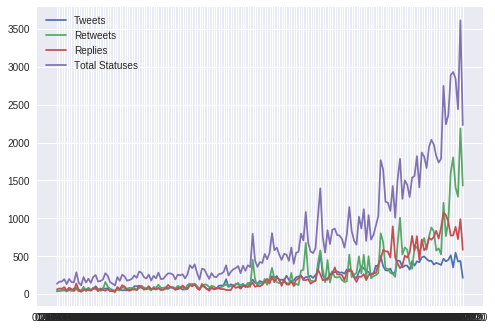

In [115]:
""" Plotting graph """

plt.style.use('seaborn')
plt.plot(daywise_df["Date"], daywise_df["Tweets"], label = "Tweets")
plt.plot(daywise_df["Date"], daywise_df["Retweets"], label = "Retweets")
plt.plot(daywise_df["Date"], daywise_df["Replies"], label = "Replies")
plt.plot(daywise_df["Date"], daywise_df["Sum"], label = "Total Statuses")
plt.legend()

plt.savefig('../results/daily_freq_analysis.png',dpi=300,bbox_inches='tight') 

In [150]:
def smooth(x,window_len=20,window='hanning'):
    if x.ndim != 1:
        raise ValueError

    if x.size < window_len:
        raise ValueError


    if window_len<3:
        return x


    if not window in ['flat', 'hanning', 'hamming', 'bartlett', 'blackman']:
        raise ValueError


    s=np.r_[x[window_len-1:0:-1],x,x[-2:-window_len-1:-1]]

    if window == 'flat': 
        w=np.ones(window_len,'d')
    else:
        w=eval('np.'+window+'(window_len)')

    y=np.convolve(w/w.sum(),s,mode='valid')
    return y

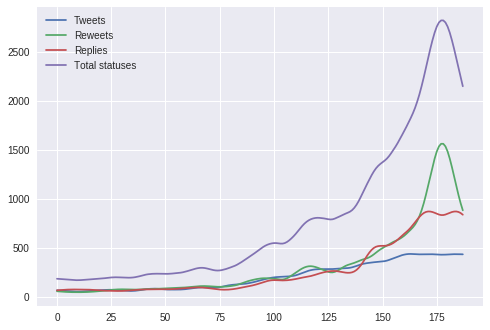

In [151]:
""" Smoothing the graph to cleary observe trends """

smoothed_tweets = smooth(daywise_df["Tweets"])
smoothed_retweets = smooth(daywise_df["Retweets"])
smoothed_replies = smooth(daywise_df["Replies"])
smoothed_sum = smooth(daywise_df["Sum"])

plt.plot(smoothed_tweets, label = "Tweets")
plt.plot(smoothed_retweets, label = "Reweets")
plt.plot(smoothed_replies, label = "Replies")
plt.plot(smoothed_sum, label = "Total statuses")
plt.legend()

plt.savefig('../results/smoothed_plot.png',dpi=300,bbox_inches='tight') 

In [152]:
""" Differencing approach """

diff = []
for ind in range(1, len(smoothed_tweets)):
    if ind == 0:
        continue
        
    else:
        temp = [smoothed_tweets[ind]-smoothed_tweets[ind-1],
                smoothed_retweets[ind]-smoothed_retweets[ind-1],
                smoothed_replies[ind]-smoothed_replies[ind-1],
                smoothed_sum[ind]-smoothed_sum[ind-1]
               ]
    diff.append(temp)

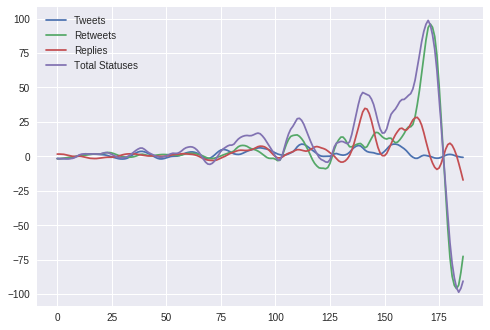

In [153]:
""" Plotting differences """

diff_columns = ["Tweet_diff", "Retweet_diff", "Reply_diff", "Sum_diff"]
diff_df = pd.DataFrame(data=diff, columns = diff_columns)

plt.style.use('seaborn')
plt.plot(diff_df["Tweet_diff"], label = "Tweets")
plt.plot(diff_df["Retweet_diff"], label = "Retweets")
plt.plot(diff_df["Reply_diff"], label = "Replies")
plt.plot(diff_df["Sum_diff"], label = "Total Statuses")
plt.legend()

plt.savefig('../results/diff_analysis.png',dpi=300,bbox_inches='tight') 

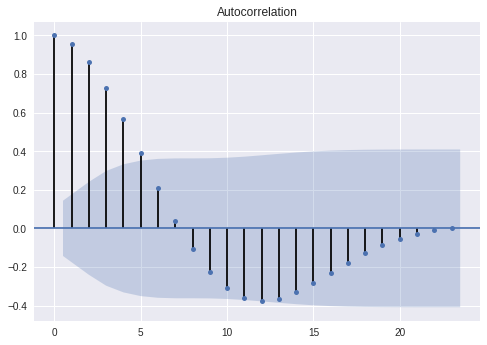

In [163]:
""" Plotting ACF of total status to determine if time series is stationery or not """

plot_acf(diff_df["Retweet_diff"])
plt.show()

In [183]:
""" Ljungbox test for final verification """

lbvalue, pvalue = acorr_ljungbox(diff_df["Tweet_diff"])
print(max(pvalue), min(lbvalue))

9.483713735571953e-40 174.08519979861148


As the p value is negligible we conclude that the trend is not white noise as per the Ljung-Box test